In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install mne

     |████████████████████████████████| 6.6MB 63kB/s 


In [ ]:
from mne.datasets.sleep_physionet.age import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling1D, Flatten, Dense, LeakyReLU, Dropout, Conv1D, GlobalMaxPooling1D, PReLU, ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
import mne
import numpy as np
import csv
import os

In [ ]:
def build_dataset(no_of_people=20):
  dataset = {'x': [], 'y':[]}
  people = [i for i in range(no_of_people)]
  sf = 100
  annotation_desc_2_event_id = {'Sleep stage W': 1,
                                'Sleep stage 1': 2,
                                'Sleep stage 2': 3,
                                'Sleep stage 3': 4,
                                'Sleep stage 4': 4,
                                'Sleep stage R': 5}
  event_id = {'Sleep stage W': 1,
              'Sleep stage 1': 2,
              'Sleep stage 2': 3,
              'Sleep stage 3/4': 4,
              'Sleep stage R': 5}
  
  tmax = 30. - 1. / sf
  
  files = fetch_data(subjects=people, recording=[1])
  
  count = 0
  for file in files:
      raw = mne.io.read_raw_edf(file[0])
      annot = mne.read_annotations(file[1])
      raw.set_annotations(annot, emit_warning=False)
      events, _ = mne.events_from_annotations(
          raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)
      epochs = mne.Epochs(raw=raw, events=events,
                                event_id=event_id, tmin=0., tmax=tmax, baseline=None)
      
      if count == 0:
          X = (epochs.get_data(picks="eeg"))[:,0,:]
          Y = epochs.events[:, 2]
          count += 1
      else:
          x = (epochs.get_data(picks="eeg"))[:,0,:]
          y = epochs.events[:, 2]
          X = np.concatenate((X, x), axis=0)
          Y = np.concatenate((Y, y), axis=0)
      
  #X = (epochs_test.get_data(picks="eeg"))[:,0,:]
  #Y = epochs_test.events[:, 2]
  dataset['x'] = X
  dataset['y'] = Y
  return dataset

In [ ]:
def normalize_vector(vector):
  normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
  return normalized_vector

In [ ]:
dataset = build_dataset(20)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data



Verifying hash adabd3b01fc7bb75c523a974f38ee3ae4e57b40f.



Verifying hash 21c998eadc8b1e3ea6727d3585186b8f76e7e70b.



Verifying hash 4d17451f7847355bcab17584de05e7e1df58c660.



Verifying hash d582a3cbe2db481a362af890bc5a2f5ca7c878dc.



Verifying hash 8b135afa7fb93bb5f1998fda50355944777c245e.



Verifying hash 91043cfe46695088b17b6a02937b25efd674c3fb.



Verifying hash 85e58dc1e3303537dade8c5827ab58328239c384.



Verifying hash 6363d8b0fdc48cf396c9abf054bb4a9696d38bdb.



Verifying hash 04d2b88d25f2ae4a65ba44cd9145bd12800a0e20.



Verifying hash f148821669bd3588187b3b430bd79adf569f86d1.



Verifying hash ea073451b65ce8a6f1a02a8cc2b89d1a162ca0ae.



Verifying hash 4159ef8a3e119d6dcc1bede806f6fbc017b27a0f.



Verifying hash 1736736e585807c14f1ae8bc87a94cae222c5170.



Verifying hash 4bf99622c67c281b25ceccd35e7050328a2946e8.



Verifying hash 1374b34f6139b6ff7e865d8243eef39ba334ef50.



Verifying hash 608024fd19a140ad233a4680e07c2495a74b69c2.



Verifying hash 0e1cc2c4e1da14ab94515e3e7e75e8ad30ec99cb.



Verifying hash 9ec663ffa5c17afcaca59d7829d77b9165102237.



Verifying hash b3502e0bd54683e973182c791aa962b804e79633.



Verifying hash 7aa63b408c769a4a983a908b6ba41d87dd743c6e.



Verifying hash 3ae168ff2c9c0c56f51205fdb10f05a4c6b2064e.



Verifying hash 60d9c3913881e11b06ad99e9870bd1ca4d93c952.



Verifying hash e490956b4dce01c46ba88a2b847f091bb54ea16e.



Verifying hash 12db1920e2f6083c8ab1f2c24fe35dfa03715e4a.



Verifying hash 33c72025a7a215ea5e255f4254cb0f93b1313369.



Verifying hash daa57ece807cb5325c6d1ce059f0e8a8d1c85391.



Verifying hash 42ff97035aae6dd34ca9437857c48ac6f2ab97df.



Verifying hash 5beef85170bdbb5cf2eea24a79f0f5c2c3975c4b.



Verifying hash 83493e1c32d441c9e5ee3de6a024bfb5e7ab9f5f.



Verifying hash 511d398f22b9b2b304de27c40740a41584ff6af2.



Verifying hash 5a92d49699d4de369d66d9462e91b0dcb3312649.



Verifying hash 37dcbd339c95322d028b3a5466812697041cc373.



Verifying hash e56ff3aa366fe9a04a0fdfdd4cd862e77e8ac807.



Verifying hash 56711b1bfed292032491f5cce57494629286a131.



Verifying hash f1a65522cb7d6c71ac47742535a12c88e2019dad.



Verifying hash dd257c8d922f08c2c8ca5236c9bf54da887c68e5.



Verifying hash 23674d20572853eb6d988d24378c52123f66500c.



Verifying hash 51fc3df2df7d4da654f3e18ed1b233d0c60cfa80.



Verifying hash d6da621dbb20dec3494a38c7d2a0363793ac5ebe.



Verifying hash defc7b9368c2d3c4ab4a294757843825a83cdb5d.
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
2650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2650 events and 3000 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
2802 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2802 events and 3

In [ ]:
print(dataset['x'].shape, dataset['x'].dtype)
print(dataset['y'].shape, dataset['y'].dtype)

(54587, 3000) float64
(54587,) int64


In [ ]:
def preprocess_dataset(dataset, test_size=0.1, val_size=0.2):
  x = np.array([normalize_vector(i) for i in dataset['x']], dtype=np.float)
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  y = np.array(dataset['y'], dtype=np.uint8)

  ohe = OneHotEncoder()
  y = ohe.fit_transform(y.reshape((-1,1))).toarray()
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42, shuffle=True)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42, shuffle=True)

  print(x_train.shape, y_train.shape)
  print(x_val.shape, y_val.shape)
  print(x_test.shape, y_test.shape)

  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocess_dataset(dataset, 0.05, 0.21)

(40967, 3000, 1) (40967, 5)
(10890, 3000, 1) (10890, 5)
(2730, 3000, 1) (2730, 5)


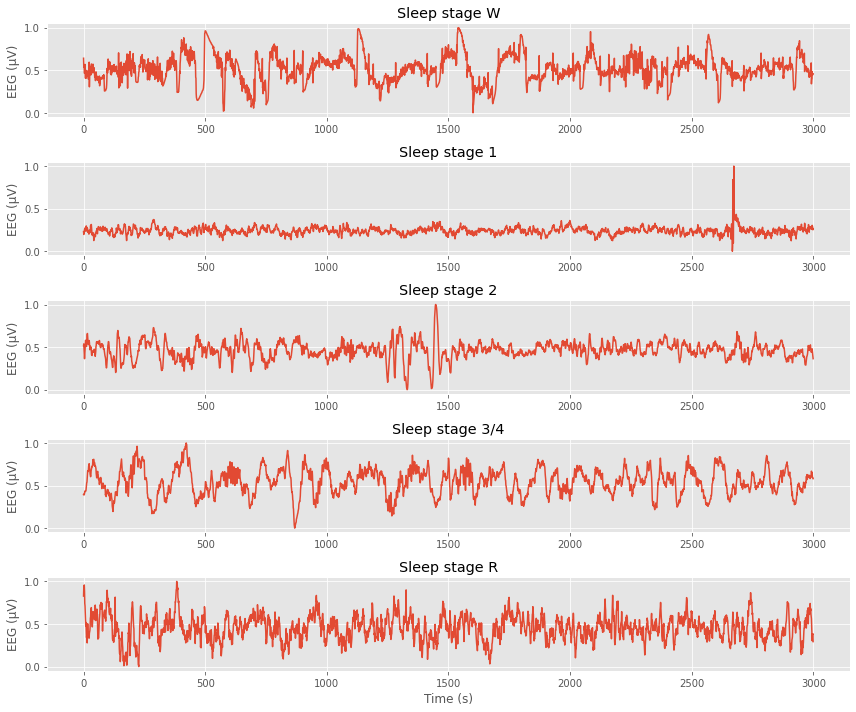

In [ ]:
import matplotlib.pyplot as plt
# 40643
# 40644
# 40642
# 40646
# 40637
plt.style.use('ggplot')
fig = plt.figure(figsize=[12, 10])

fig.add_subplot(5,1,1)
plt.plot(x_train[40643])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage W")

fig.add_subplot(5,1,2)
plt.plot(x_train[40644])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage 1")

fig.add_subplot(5,1,3)
plt.plot(x_train[40642])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage 2")

fig.add_subplot(5,1,4)
plt.plot(x_train[40646])
plt.ylabel('EEG (μV)')
plt.title("Sleep stage 3/4")

fig.add_subplot(5,1,5)
plt.plot(x_train[40637])
plt.xlabel('Time (s)')
plt.ylabel('EEG (μV)')
plt.title("Sleep stage R")

plt.tight_layout()
plt.savefig('./classes.png')
plt.show()

In [ ]:
plt.figure(figsize=[12,10])
plt.style.use('ggplot')

y_tr = y_train.argmax(axis=1).astype(np.uint8) + 1
y_va = y_val.argmax(axis=1).astype(np.uint8) + 1
y_te = y_test.argmax(axis=1).astype(np.uint8) + 1

hist = plt.hist([y_tr, y_va, y_te], color=['orange', 'green','purple'], bins=5)
plt.legend(['train labels', 'validation labels','test labels'], loc='best')
plt.xlabel('Sleep stage classes')
plt.ylabel('Count')
plt.savefig('./histogram.png')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
plt.figure(figsize=[7,5])
plt.style.use('ggplot')

x_tr = np.reshape(x_train, (x_train.shape[0], 3000))

# pca = PCA(2)
# proj = pca.fit_transform(x_te)
# plt.scatter(proj[:, 0], proj[:, 1],c=y_te[:], s=8, cmap='gist_rainbow')
# plt.xlabel('1st Principal')
# plt.ylabel('2nd Principal')
# plt.colorbar()
# plt.savefig('./x_test_pca.png')
# plt.show()

<Figure size 504x360 with 0 Axes>

In [ ]:
def build_model(time_steps, features, classes):
  i = Input(shape=(time_steps, features))

  x = Conv1D(16, 3, strides=1, padding='same', kernel_regularizer=l2(0.1), dilation_rate=2)(i)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2)(x)

  x = Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.1), dilation_rate=2)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2)(x)

  x = Conv1D(64, 3, strides=1, padding='same', kernel_regularizer=l2(0.1), dilation_rate=2)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2)(x)

  x = Conv1D(128, 3, strides=1, padding='same', kernel_regularizer=l2(0.1),  dilation_rate=2)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2)(x)

  x = Flatten()(x)
  x = Dropout(0.6)(x)

  x = Dense(512, kernel_regularizer=l2(0.1))(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Dropout(0.6)(x)

  x = Dense(classes, activation='softmax')(x)

  model = Model(i, x)
  return model

In [ ]:
model = build_model(3000, 1, classes=5)
# model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='./model.png', show_shapes=True, show_layer_names=True)

In [ ]:
INIT_LR = 0.0001
EPOCHS = 15
BATCH_SIZE = 16
STEPS_PER_EPOCH = x_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = x_val.shape[0] // BATCH_SIZE

def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0

  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

callbacks = [LearningRateScheduler(poly_decay)]

In [ ]:
opt = Adam(lr=INIT_LR, amsgrad=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [ ]:
r = model.fit(
  x_train, y_train,
  validation_data=(x_val, y_val),
  epochs=EPOCHS, batch_size=BATCH_SIZE,
  steps_per_epoch=STEPS_PER_EPOCH,
  validation_steps=VALIDATION_STEPS,
  callbacks=callbacks
)

Epoch 1/15
2560/2560 [==============================] - 76s 30ms/step - loss: 26.1782 - accuracy: 0.7508 - val_loss: 6.5181 - val_accuracy: 0.8158 - lr: 1.0000e-04
Epoch 2/15
2560/2560 [==============================] - 76s 30ms/step - loss: 4.6493 - accuracy: 0.8456 - val_loss: 3.3104 - val_accuracy: 0.9004 - lr: 9.3333e-05
Epoch 3/15
2560/2560 [==============================] - 76s 30ms/step - loss: 2.9195 - accuracy: 0.8640 - val_loss: 2.3754 - val_accuracy: 0.8964 - lr: 8.6667e-05
Epoch 4/15
2560/2560 [==============================] - 75s 29ms/step - loss: 2.2735 - accuracy: 0.8717 - val_loss: 2.0158 - val_accuracy: 0.8826 - lr: 8.0000e-05
Epoch 5/15
2560/2560 [==============================] - 75s 29ms/step - loss: 1.8909 - accuracy: 0.8801 - val_loss: 1.7427 - val_accuracy: 0.9017 - lr: 7.3333e-05
Epoch 6/15
2560/2560 [==============================] - 75s 29ms/step - loss: 1.6767 - accuracy: 0.8817 - val_loss: 1.4870 - val_accuracy: 0.9031 - lr: 6.6667e-05
Epoch 7/15
2560/2560 

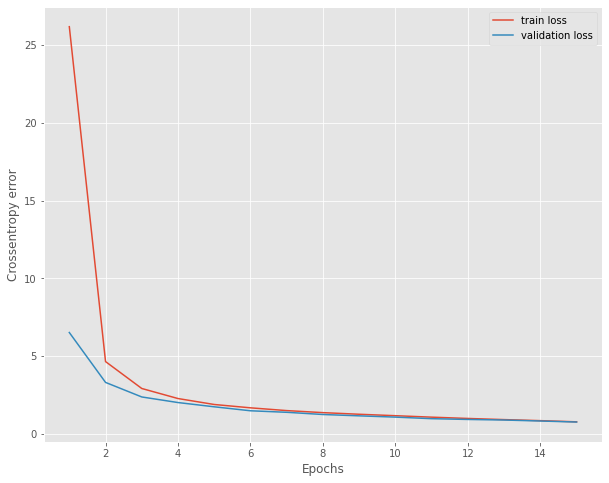

In [ ]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(np.arange(1,16), r.history['loss'], label='train loss')
plt.plot(np.arange(1,16), r.history['val_loss'], label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Crossentropy error')
plt.legend(loc='best')
plt.savefig('./error.png')
plt.show()

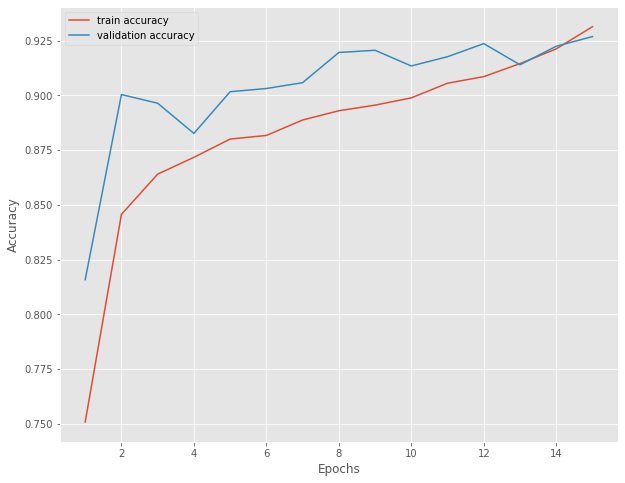

In [ ]:
plt.figure(figsize=[10,8])
plt.style.use('ggplot')

plt.plot(np.arange(1,16), r.history['accuracy'], label='train accuracy')
plt.plot(np.arange(1,16), r.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig('./accuracy.png')
plt.show()

In [ ]:
print(model.evaluate(x_test, y_test, batch_size=BATCH_SIZE))

171/171 [==============================] - 1s 8ms/step - loss: 0.7600 - accuracy: 0.9275
[0.7600206136703491, 0.9274725317955017]


In [ ]:
preds = model.predict(x_test).argmax(axis=1)

In [ ]:
ohe = OneHotEncoder()
preds = ohe.fit_transform(preds.reshape((-1,1))).toarray()

In [ ]:
target_names = ['class W', 'class 1', 'class 2', 'class 3/4', 'class R']
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

     class W       0.97      0.99      0.98      1819
     class 1       0.58      0.23      0.33        65
     class 2       0.89      0.86      0.88       490
   class 3/4       0.82      0.90      0.86       157
     class R       0.78      0.78      0.78       199

   micro avg       0.93      0.93      0.93      2730
   macro avg       0.81      0.75      0.76      2730
weighted avg       0.92      0.93      0.92      2730
 samples avg       0.93      0.93      0.93      2730



In [ ]:
save_model(model, './model_1dconv_e{}-bs{}-a{:.2f}-va{:.2f}.h5'.format(EPOCHS, BATCH_SIZE, 100*r.history['accuracy'][-1], 100*r.history['val_accuracy'][-1]))

In [ ]:
model.save_weights('./model_1dconv_weights_e{}-bs{}-a{:.2f}-va{:.2f}.h5'.format(EPOCHS, BATCH_SIZE, 100*r.history['accuracy'][-1], 100*r.history['val_accuracy'][-1]))

In [ ]:
def plot_confusion_matrix_custom(cm, classes, normalize=False, title='Confusion matrix', cmap='Reds'):
  import itertools
  plt.figure(figsize=[10,8])
  plt.grid(b=None)
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()

Confusion matrix, without normalization
[[1798    4    9    1    7]
 [  27   15    8    0   15]
 [  14    1  423   30   22]
 [   0    0   15  141    1]
 [  19    6   19    0  155]]


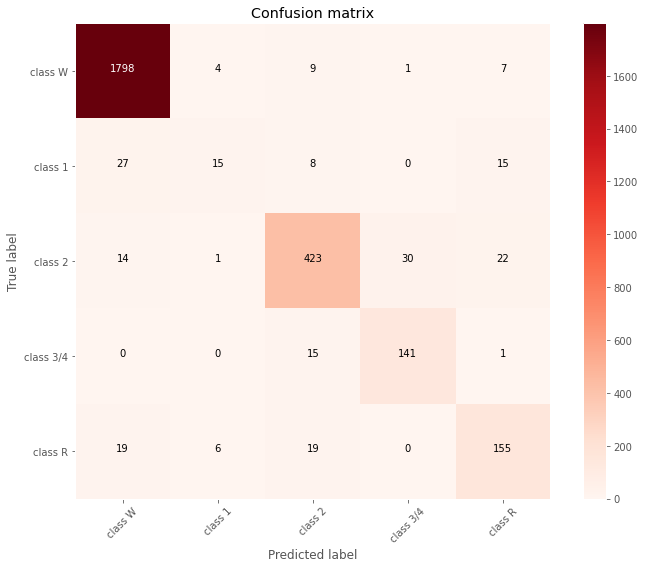

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

confusion_matrix_output =confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
plot_confusion_matrix_custom(confusion_matrix_output, classes=['class W', 'class 1', 'class 2', 'class 3/4', 'class R'], title='Confusion matrix')

In [ ]:
 from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle
def plot_custom_roc(y_test, preds):
  plt.figure(figsize=[10,8])
  n_classes = 5
  lw = 2
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=[10,10])
  classes=['class W', 'class 1', 'class 2', 'class 3/4', 'class R']
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
  for i, color in zip(range(n_classes), colors):
      class_name = classes[i]
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(class_name, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

<Figure size 720x576 with 0 Axes>

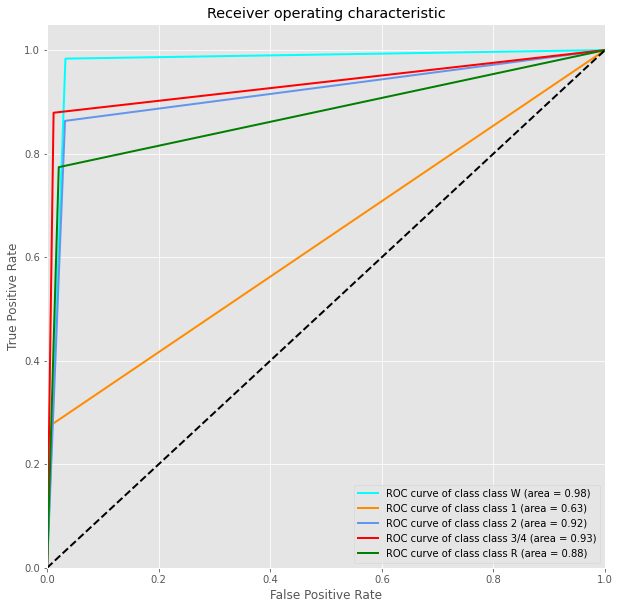

In [ ]:
plot_custom_roc(y_test, preds)